In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [ ]:
#Regression-classification
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [ ]:
#Polynomial model
def poly_model(x, beta, noise_std=0):
    """
    INPUT
        x: x vector
        beta: polynomial parameters
        noise_std: enable noisy sampling (gaussian noise, zero mean, noise_std std)
    """
    pol_order = len(beta)
    x_matrix = np.array([x**i for i in range(pol_order)]).transpose()
    y = np.matmul(x_matrix, beta)
    noise = np.random.randn(len(y)) * noise_std
    return y + noise

In [ ]:
beta_true = [-1.45, 1.12, 2.3]
noise_std = 0.2
np.random.seed(4)

In [ ]:
### Train data
num_train_points = 20
x_train = np.random.rand(num_train_points)
y_train = poly_model(x_train, beta_true, noise_std)
with open('train_data.csv', 'w') as f:
    data = [f"{x},{y}" for x, y in zip(x_train, y_train)]
    f.write('\n'.join(data))

### Validation data
num_val_points = 20
x_val = np.random.rand(num_val_points)
y_val = poly_model(x_val, beta_true, noise_std)
with open('val_data.csv', 'w') as f:
    data = [f"{x},{y}" for x, y in zip(x_val, y_val)]
    f.write('\n'.join(data))

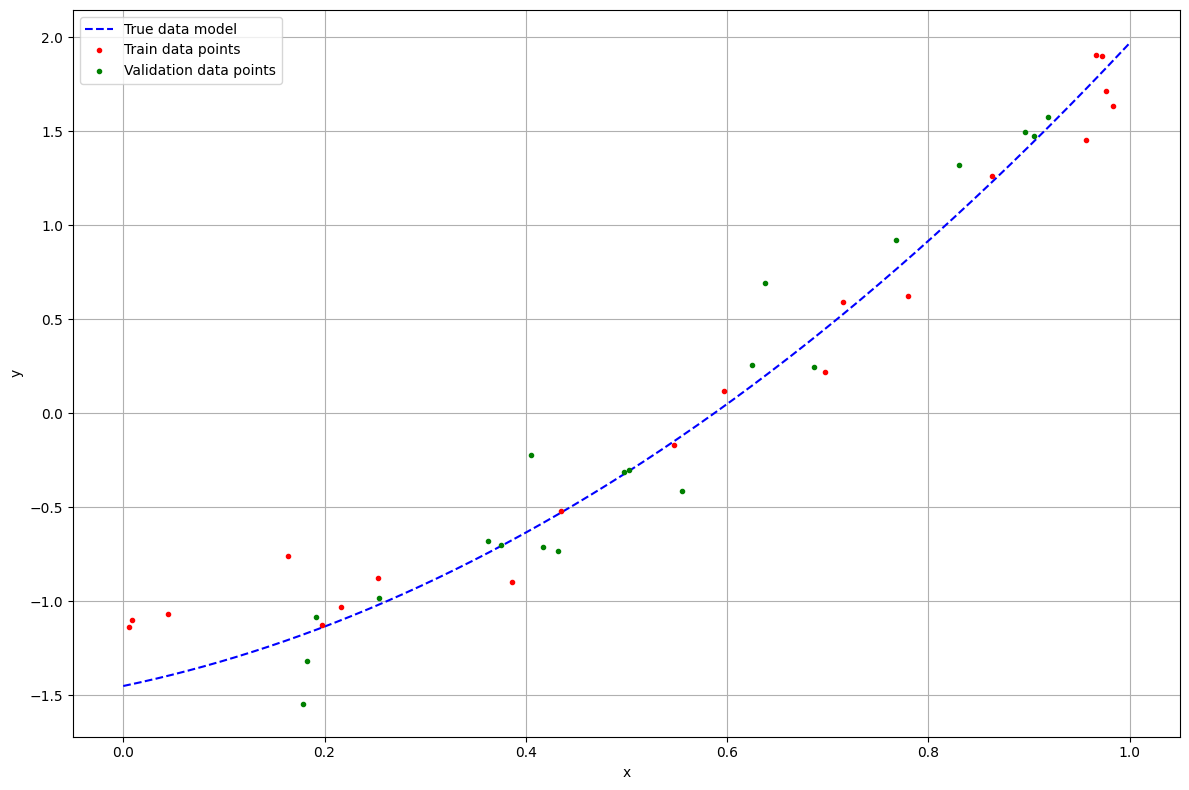

In [ ]:
plt.figure(figsize=(12,8))
x_highres = np.linspace(0,1,1000)
plt.plot(x_highres, poly_model(x_highres, beta_true), color='b', ls='--', label='True data model')
plt.plot(x_train, y_train, color='r', ls='', marker='.', label='Train data points')
plt.plot(x_val, y_val, color='g', ls='', marker='.', label='Validation data points')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
#Define a 2 layer feedforward neural network. Since this is a regression problem, no activation function has to be applied to the output layer
class Net(nn.Module):
  def __init__(self, Ni, Nh1, Nh2, No):
    super().__init__()

    self.fc1 = nn.Linear(in_features=Ni, out_features=Nh1)
    self.fc2 = nn.Linear(in_features=Nh1, out_features=Nh2)
    self.out = nn.Linear(in_features=Nh2, out_features=No)
    self.act = nn.Sigmoid()
  def forward(self, x, additional_out=False):
    x = self.act(self.fc1(x))
    x = self.act(self.fc2(x))
    x = self.out(x)  #No activation function applied to the output layer
    return x




In [ ]:
class CsvDataset(Dataset):

    def __init__(self, csv_file, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.transform = transform
        # Read the file and split the lines in a list
        with open(csv_file, 'r') as f:
            lines = f.read().split('\n')
        # Get x and y values from each line and append to self.data
        self.data = []
        for line in lines:
            sample = line.split(',')
            self.data.append((float(sample[0]), float(sample[1])))
        # Now self.data contains all our dataset.
        # Each element of the list self.data is a tuple: (input, output)

    def __len__(self):
        # The length of the dataset is simply the length of the self.data list
        return len(self.data)

    def __getitem__(self, idx):
        # Our sample is the element idx of the list self.data
        sample = self.data[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample

In [ ]:
class ToTensor(object):
    """Convert sample to Tensors."""

    def __call__(self, sample):
        x, y = sample
        return (torch.tensor([x]).float(),
                torch.tensor([y]).float())

In [ ]:
composed_transform = transforms.Compose([ToTensor()])
train_dataset = CsvDataset('train_data.csv', transform = composed_transform)
val_dataset = CsvDataset('val_data.csv', transform = composed_transform)

In [ ]:
#DataLoader
#Shuffle only of the training set, not of the validation set.

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False, num_workers=0)


In [ ]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

Training device: cuda


In [ ]:
#Initialize the network
torch.manual_seed(0)
Ni=1
Nh1=128
Nh2=256
No=1

net = Net(Ni, Nh1, Nh2, No)
net.to(device) #port the nn to cuda (GPU)



Net(
  (fc1): Linear(in_features=1, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=1, bias=True)
  (act): Sigmoid()
)

In [ ]:
loss_fn = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)


In [ ]:
num_epochs = 3000
train_loss_log = []
val_loss_log = []

for epoch_num in range(num_epochs):
  train_loss = []
  net.train()
  for sample_batched in train_dataloader:
    x_batch = sample_batched[0].to(device)
    label_batch = sample_batched[1].to(device)
    out = net(x_batch)
    loss = loss_fn(out, label_batch)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_batch = loss.detach().cpu().numpy()
    train_loss.append(loss_batch)
  train_loss = np.mean(train_loss)
  print(f'Average training loss: {train_loss}')
  train_loss_log.append(train_loss)

  val_loss = []
  net.eval()
  with torch.no_grad():
    for sample_batched in val_dataloader:
      x_batch = sample_batched[0].to(device)
      label_batch = sample_batched[1].to(device)

      out = net(x_batch)
      loss = loss_fn(out, label_batch)
      loss_batch = loss.detach().cpu().numpy()
      val_loss.append(loss_batch)
    val_loss = np.mean(val_loss)
    print(f'Average validation loss: {val_loss}')
    val_loss_log.append(val_loss)





Output streaming troncato alle ultime 5000 righe.
Average training loss: 0.10262627899646759
Average validation loss: 0.1279371678829193
Average training loss: 0.10114256292581558
Average validation loss: 0.12999631464481354
Average training loss: 0.1002410426735878
Average validation loss: 0.1307486593723297
Average training loss: 0.10037360340356827
Average validation loss: 0.12974821031093597
Average training loss: 0.10061416774988174
Average validation loss: 0.12993688881397247
Average training loss: 0.10016224533319473
Average validation loss: 0.13076165318489075
Average training loss: 0.10031378269195557
Average validation loss: 0.1315237283706665
Average training loss: 0.10009755939245224
Average validation loss: 0.1296469271183014
Average training loss: 0.10034877061843872
Average validation loss: 0.1289990395307541
Average training loss: 0.09962242096662521
Average validation loss: 0.12835951149463654
Average training loss: 0.09955374896526337
Average validation loss: 0.128875

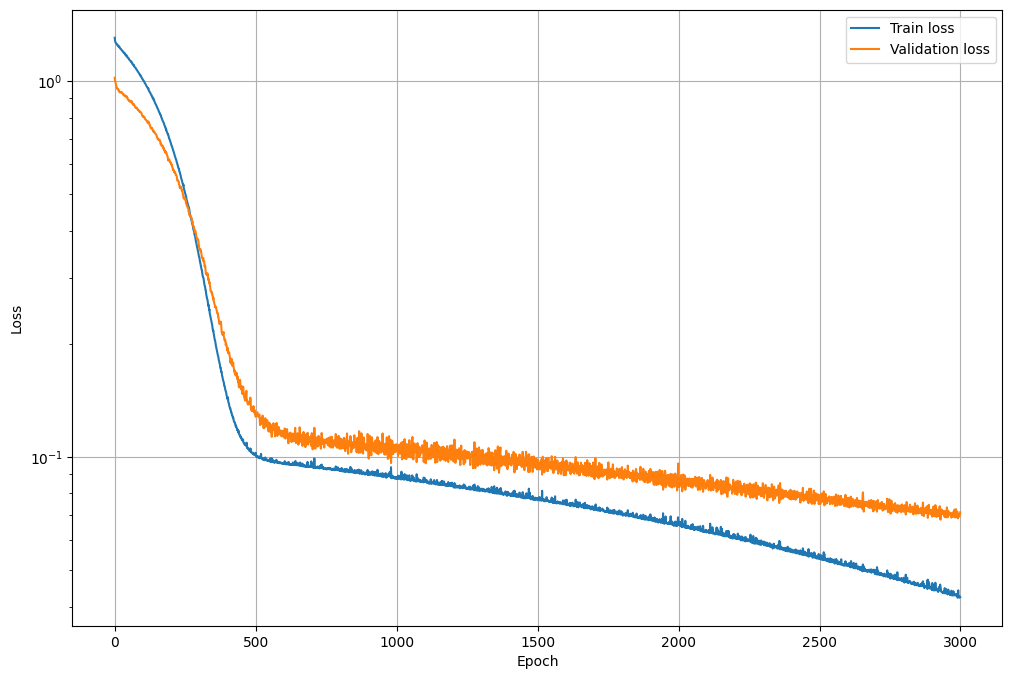

In [ ]:
# Plot losses
plt.figure(figsize=(12,8))
plt.semilogy(train_loss_log, label='Train loss')
plt.semilogy(val_loss_log, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

In [ ]:
x_vec = torch.linspace(0,1,1000)
x_vec = x_vec.to(device)
x_vec = x_vec.unsqueeze(-1)  # Adding a dimension to the input vector
print(f"Input shape: {x_vec.shape}")

net.eval()
with torch.no_grad():
  y_vec=net(x_vec)
print(f'Output shape {y_vec.shape}')

#Expected output
beta_true = [-1.45, 1.12, 2.3]
true_model = poly_model(x_vec.cpu().numpy(), beta_true).squeeze()


Input shape: torch.Size([1000, 1])
Output shape torch.Size([1000, 1])


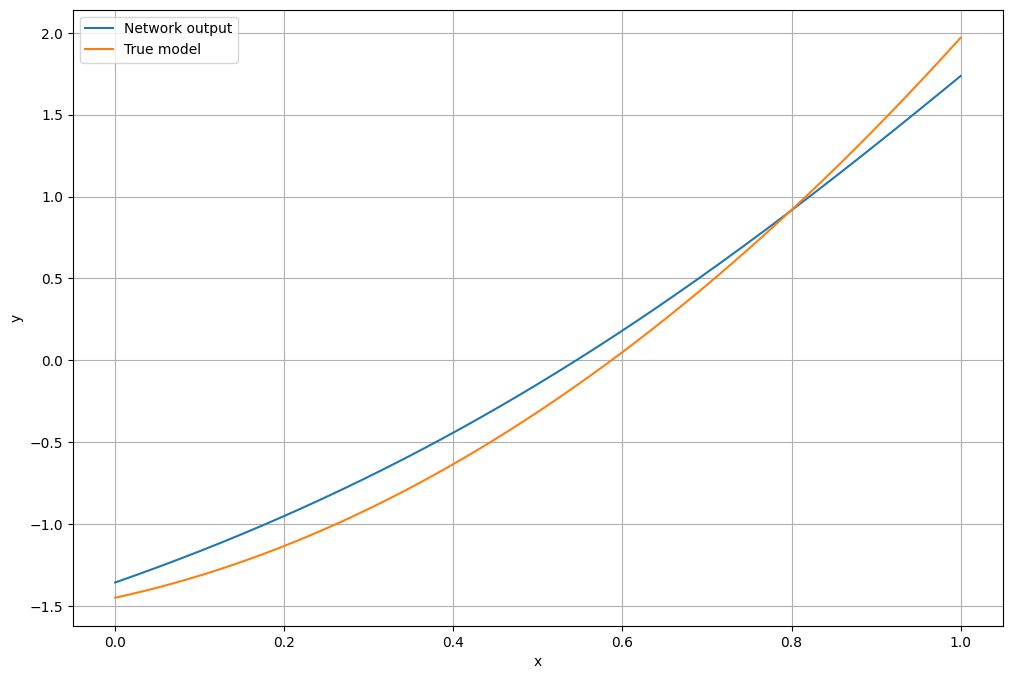

In [ ]:
# Convert x_vec and y_vec to numpy one dimensional arrays
x_vec = x_vec.squeeze().cpu().numpy()
y_vec = y_vec.squeeze().cpu().numpy()

# Plot output
plt.figure(figsize=(12,8))
plt.plot(x_vec, y_vec, label='Network output')
plt.plot(x_vec, true_model, label='True model')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.legend()
plt.show()

Input shape: torch.Size([1000, 1])
Output shape: torch.Size([1000, 1])


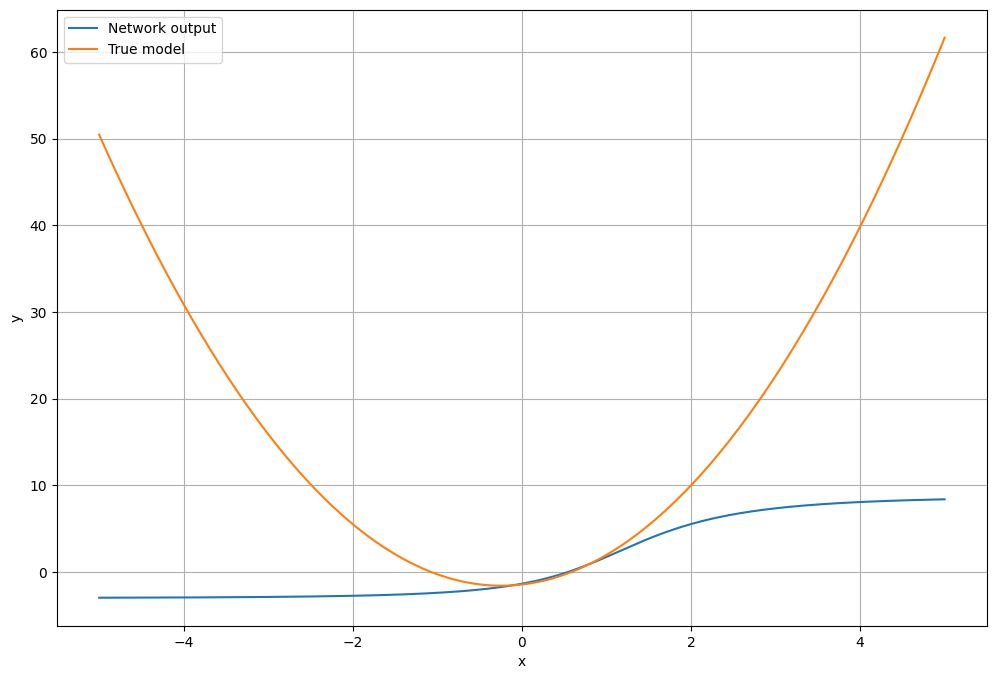

In [ ]:
#Predict outside the range
# Input vector
x_vec = torch.linspace(-5,5,1000)
x_vec = x_vec.to(device)
x_vec = x_vec.unsqueeze(-1)  # Adding a dimension to the input vector
print(f"Input shape: {x_vec.shape}")

# Network output
net.eval()
with torch.no_grad():
    y_vec = net(x_vec)
print(f"Output shape: {y_vec.shape}")

# Expected output
beta_true = [-1.45, 1.12, 2.3]
true_model = poly_model(x_vec.cpu().numpy(), beta_true).squeeze()

# Convert x_vec and y_vec to numpy one dimensional arrays
x_vec = x_vec.squeeze().cpu().numpy()
y_vec = y_vec.squeeze().cpu().numpy()

# Plot output
plt.figure(figsize=(12,8))
plt.plot(x_vec, y_vec, label='Network output')
plt.plot(x_vec, true_model, label='True model')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.legend()
plt.show()

In [ ]:
#access to weights and biases
h1_w = net.fc1.weight.data.cpu().numpy()
h1_b = net.fc1.bias.data.cpu().numpy()

h2_w = net.fc2.weight.data.cpu().numpy()
h2_b = net.fc2.bias.data.cpu().numpy()

out_w = net.out.weight.data.cpu().numpy()
out_b = net.out.bias.data.cpu().numpy()



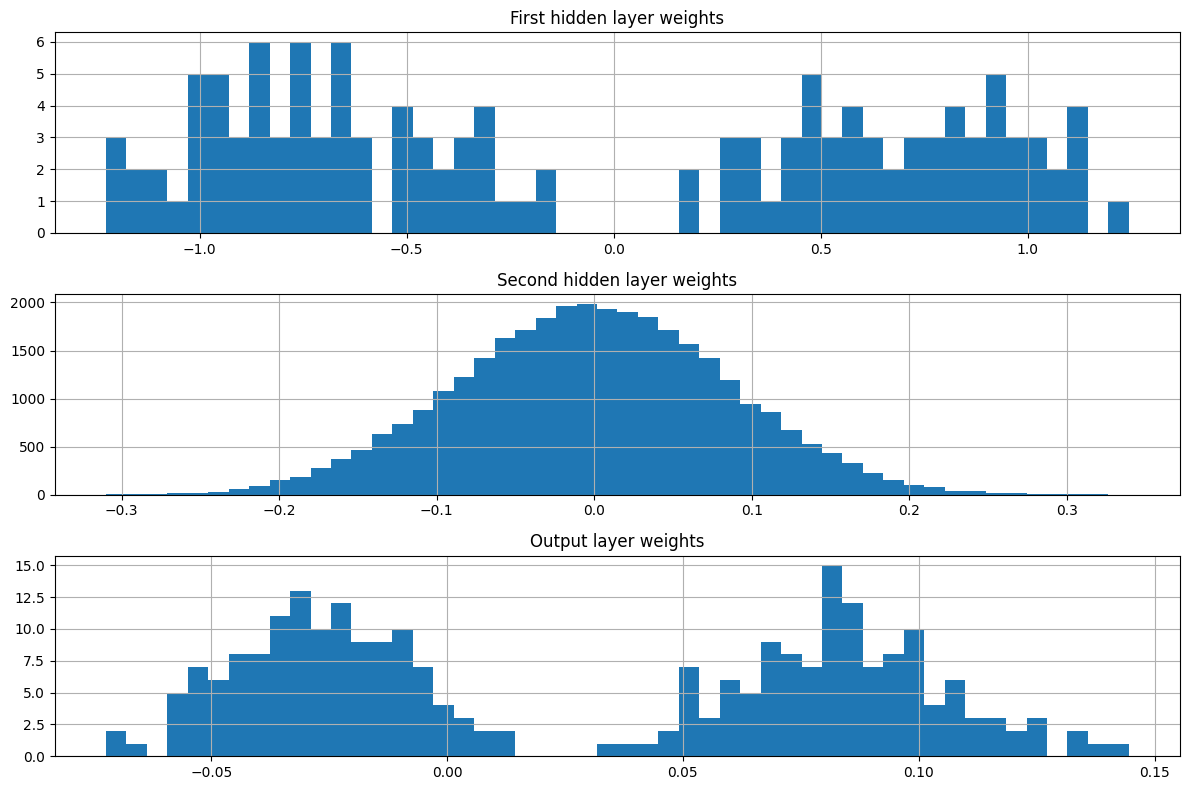

In [ ]:
#Histogram of weights and biases
fig, axs = plt.subplots(3,1, figsize=(12,8))
axs[0].hist(h1_w.flatten(),50)
axs[0].set_title('First hidden layer weights')
axs[1].hist(h2_w.flatten(),50)
axs[1].set_title('Second hidden layer weights')
axs[2].hist(out_w.flatten(), 50)
axs[2].set_title('Output layer weights')
[ax.grid() for ax in axs]
plt.tight_layout()
plt.show()

In [ ]:
#Save network parameters
#save the network state
#The dictionary includes all the parameters of the network
net_state_dict = net.state_dict()
print(net_state_dict.keys())
torch.save(net_state_dict, 'net_parameters.torch')

odict_keys(['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'out.weight', 'out.bias'])


In [ ]:
#Reload the network: NB the network has to be initialized
net = Net(Ni, Nh1, Nh2, No)
net_state_dict = torch.load('net_parameters.torch')
net.load_state_dict(net_state_dict)

<ipython-input-23-cf4a6258bffa>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net_state_dict = torch.load('net_parameters.torch')


<All keys matched successfully>

In [ ]:
#Save and load the optimizer state (needed for training)
optimizer_state_dict = optimizer.state_dict()
torch.save(optimizer_state_dict, 'optimizer_state.torch')
#reload the optimizer
optimizer = optim.Adam(net.parameters(), lr=0.001)
opt_state_dict = torch.load('optimizer_state.torch')
optimizer.load_state_dict(opt_state_dict)

<ipython-input-24-08c62618bf3c>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  opt_state_dict = torch.load('optimizer_state.torch')


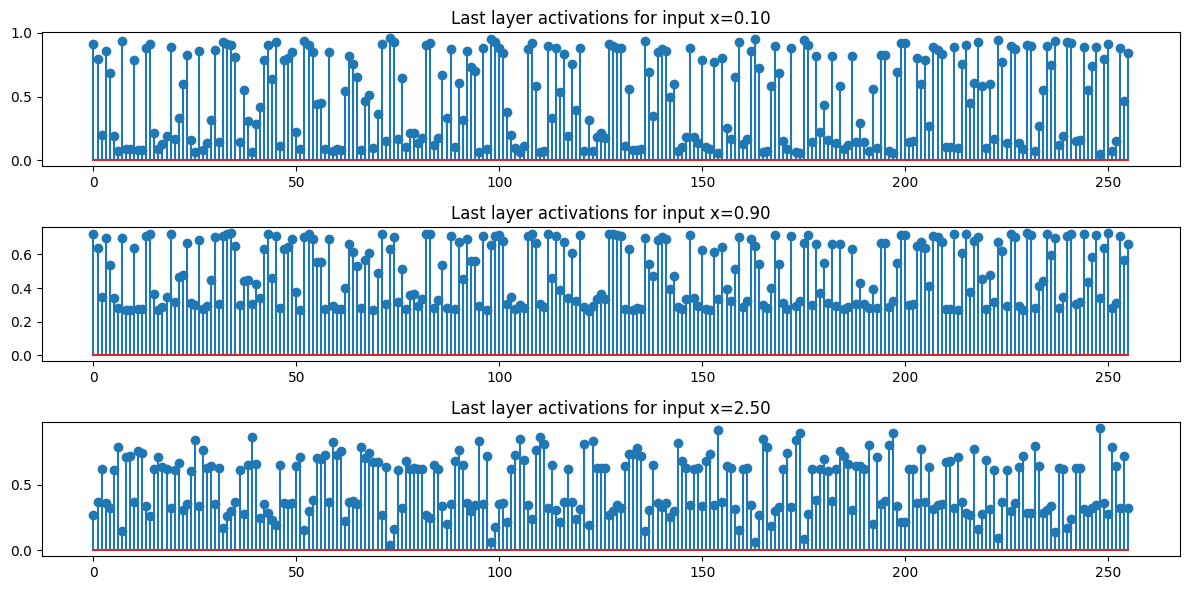

In [ ]:
#Get the activations

def get_activation(layer, input, output):
    global activation
    activation = torch.sigmoid(output)

#register hook
hook_handle = net.fc2.register_forward_hook(get_activation)

net = net.to(device)
net.eval()
with torch.no_grad():
    x1 = torch.tensor([0.1]).float().to(device)
    y1 = net(x1)
    z1 = activation
    x2 = torch.tensor([0.9]).float().to(device)
    y2 = net(x2)
    z2 = activation
    x3 = torch.tensor([2.5]).float().to(device)
    y3 = net(x3)
    z3 = activation

hook_handle.remove()

### Plot activations
fig, axs = plt.subplots(3, 1, figsize=(12,6))
axs[0].stem(z1.cpu().numpy())
axs[0].set_title('Last layer activations for input x=%.2f' % x1)
axs[1].stem(z2.cpu().numpy())
axs[1].set_title('Last layer activations for input x=%.2f' % x2)
axs[2].stem(z3.cpu().numpy())
axs[2].set_title('Last layer activations for input x=%.2f' % x3)
plt.tight_layout()
plt.show()

In [ ]:
import itertools

np.random.seed(123)

def bidimensional_model(x1, x2):
    a = 1
    b = 1
    cx1 = 0
    cx2 = 0
    out = (x1 - cx1)**2 / a**2 + (x2 - cx2)**2 / b **2 < 1
    a = 2
    b = 2
    cx1 = 5
    cx2 = 5
    out |= (x1 - cx1)**2 / a**2 + (x2 - cx2)**2 / b **2 < 1
    a = 1
    b = 2
    cx1 = -2.5
    cx2 = 5
    out |= (x1 - cx1)**2 / a**2 + (x2 - cx2)**2 / b **2 < 1
    a = 3
    b = 1
    cx1 = -6
    cx2 = -2.5
    out |= (x1 - cx1)**2 / a**2 + (x2 - cx2)**2 / b **2 < 1
    a = 2
    b = 4
    cx1 = -7.5
    cx2 = -5
    out |= (x1 - cx1)**2 / a**2 + (x2 - cx2)**2 / b **2 < 1
    a = 6
    b = 1
    cx1 = -7.5
    cx2 = 5
    out |= (x1 - cx1)**2 / a**2 + (x2 - cx2)**2 / b **2 < 1
    a = 4
    b = 4
    cx1 = 7.5
    cx2 = -7.5
    out |= (x1 - cx1)**2 / a**2 + (x2 - cx2)**2 / b **2 < 1
    a = 3
    b = 2
    cx1 = -1
    cx2 = -6
    out |= (x1 - cx1)**2 / a**2 + (x2 - cx2)**2 / b **2 < 1
    a = 2
    b = 5
    cx1 = 1
    cx2 = 6
    out |= (x1 - cx1)**2 / a**2 + (x2 - cx2)**2 / b **2 < 1
    a = 2
    b = 2
    cx1 = 6
    cx2 = 0
    out |= (x1 - cx1)**2 / a**2 + (x2 - cx2)**2 / b **2 < 1
    return out.astype(int)

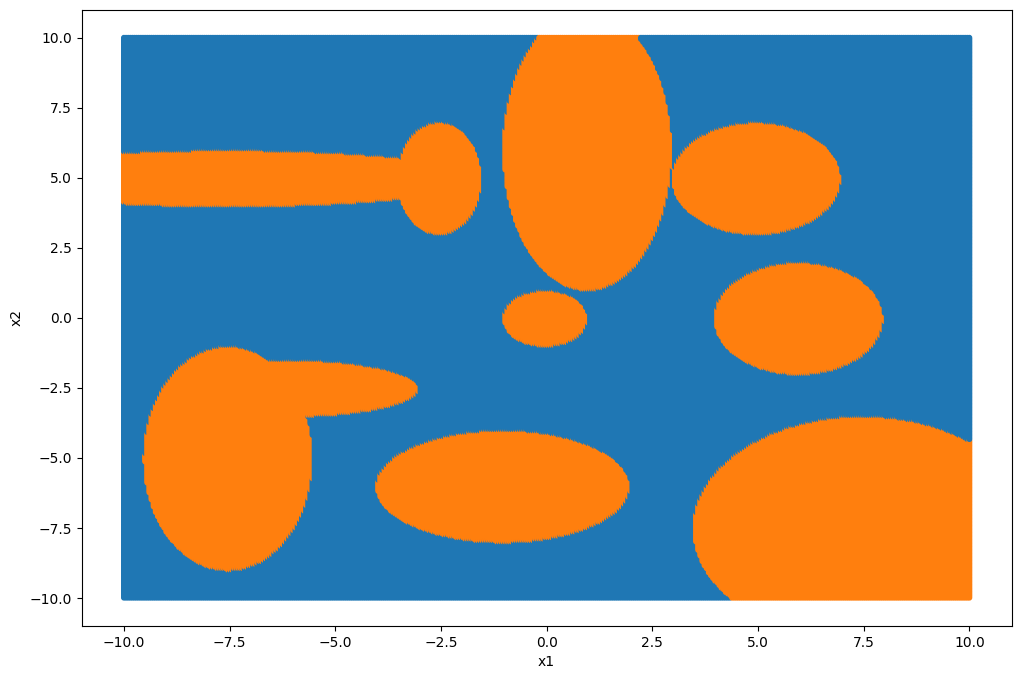

In [ ]:
### PLOT MODEL
# Input grid
x1 = np.linspace(-10, 10, 400)
x2 = np.linspace(-10, 10, 400)
x_prod = [x for x in itertools.product(x1, x2)]
x1 = np.array([x[0] for x in x_prod])
x2 = np.array([x[1] for x in x_prod])
# Evaluate out
y = bidimensional_model(x1, x2)
# Scatter plot
fig, ax = plt.subplots(figsize=(12,8))
colors = np.array(['C0', 'C1'])
ax.scatter(x1, x2, c=colors[y], s=10, marker='o')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
fig.show()

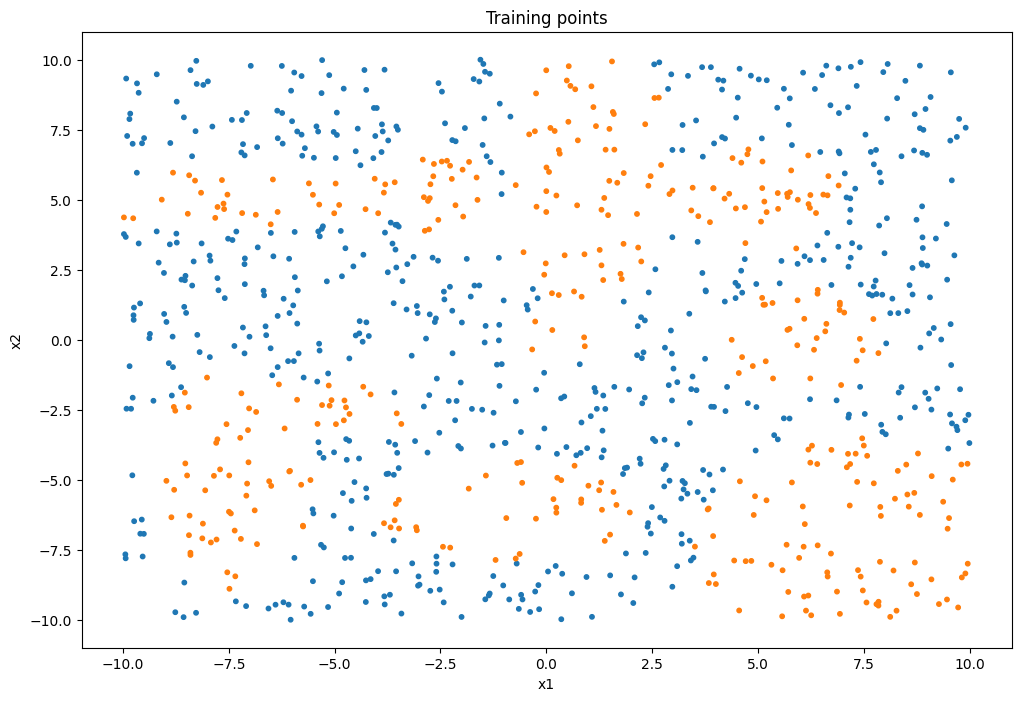

In [ ]:
import pandas as pd

### Train data
num_points = 1000
x1 = np.random.uniform(-10, 10, num_points)
x2 = np.random.uniform(-10, 10, num_points)
y = bidimensional_model(x1, x2)
train_df = pd.DataFrame({'x1': x1, 'x2': x2, 'y': y})
train_df.to_csv('classifier_train_data.csv', index=False)

fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(x1, x2, c=colors[y], s=10, marker='o')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_title('Training points')
fig.show()

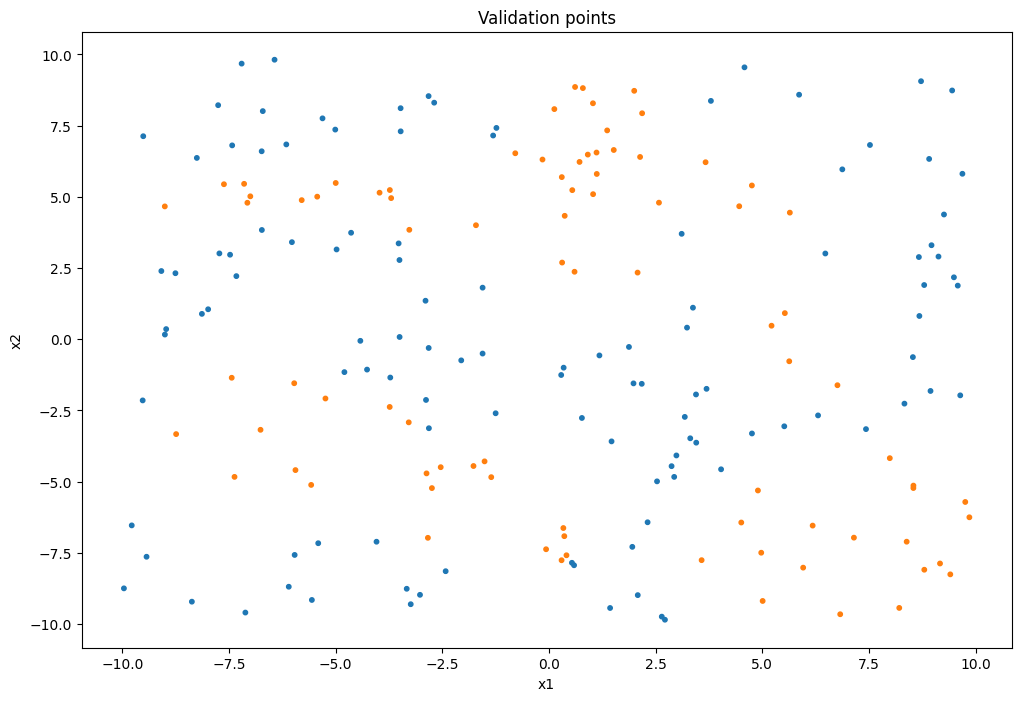

In [ ]:
### Validation data
num_points = 200
x1 = np.random.uniform(-10, 10, num_points)
x2 = np.random.uniform(-10, 10, num_points)
y = bidimensional_model(x1, x2)
val_df = pd.DataFrame({'x1': x1, 'x2': x2, 'y': y})
val_df.to_csv('classifier_val_data.csv', index=False)

fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(x1, x2, c=colors[y], s=10, marker='o')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_title('Validation points')
fig.show()

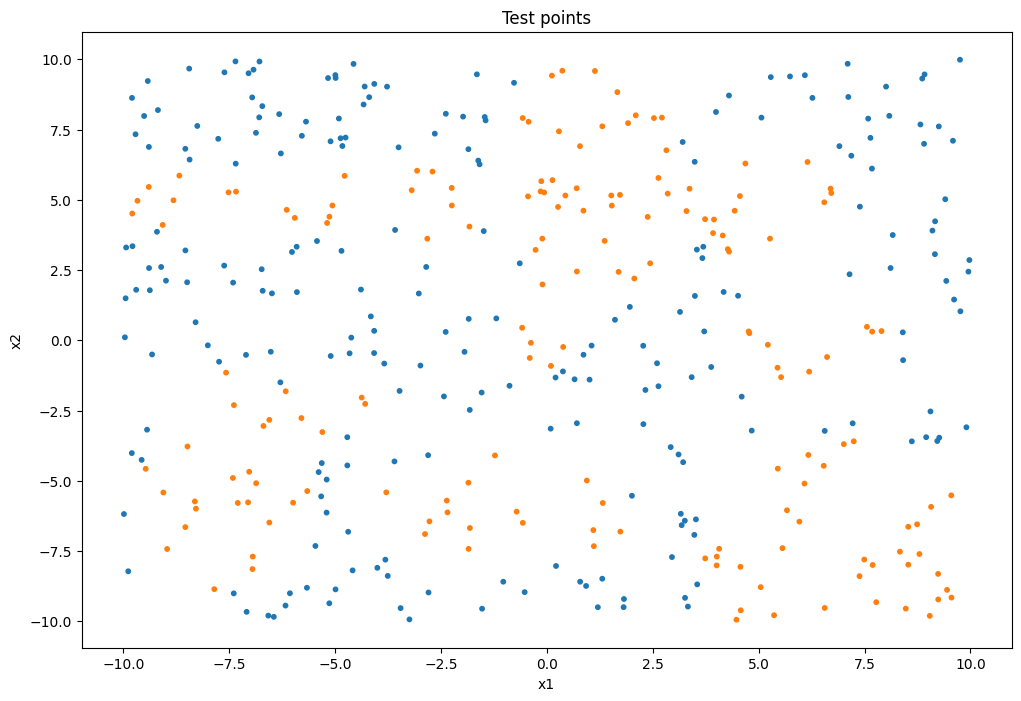

In [ ]:
### Test data
num_points = 400
x1 = np.random.uniform(-10, 10, num_points)
x2 = np.random.uniform(-10, 10, num_points)
y = bidimensional_model(x1, x2)
val_df = pd.DataFrame({'x1': x1, 'x2': x2, 'y': y})
val_df.to_csv('classifier_test_data.csv', index=False)

fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(x1, x2, c=colors[y], s=10, marker='o')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_title('Test points')
fig.show()

In [ ]:
class ClassifierDataset(Dataset):

    def __init__(self, csv_file, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file.
            transform (callable, optional): Optional transform to be applied
                on a sample."""

        self.transform = transform
        self.df = pd.read_csv(csv_file)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        sample = ([row.x1, row.x2], row.y)
        if self.transform:
            sample = self.transform(sample)
        return sample

In [ ]:
class ToTensor(object):
    """Convert sample to Tensors."""

    def __call__(self, sample):
        x, y = sample
        return (torch.Tensor(x).float(),
                torch.Tensor([y]).float())


In [ ]:
composed_transform = transforms.Compose([ToTensor()])

train_dataset = ClassifierDataset('classifier_train_data.csv', transform = composed_transform)
val_dataset   = ClassifierDataset('classifier_val_data.csv', transform = composed_transform)
test_dataset  = ClassifierDataset('classifier_test_data.csv', transform = composed_transform)

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size = 200, shuffle = True, num_workers = 0) #batch size = 200
val_dataloader   = DataLoader(val_dataset, batch_size = len(val_dataset), shuffle = False, num_workers = 0) #The batch size can be equal to the validation set size if it fits in memory
test_dataloader  = DataLoader(test_dataset, batch_size = len(test_dataset), shuffle = False, num_workers =0)

In [ ]:
class Net(nn.Module):
  #linear output to stabilize the network. The output does not represent the probability of the given class. Has to be calculated by the sign
  #of the outputted result

    def __init__(self, Ni, Nh1, Nh2, No):
        """
        Ni - Input size
        Nh1 - Neurons in the 1st hidden layer
        Nh2 - Neurons in the 2nd hidden layer
        No - Output size
        """
        super().__init__()

        print('Network initialized')
        self.fc1 = nn.Linear(in_features=Ni, out_features=Nh1)
        self.fc2 = nn.Linear(in_features=Nh1, out_features=Nh2)
        self.out = nn.Linear(in_features=Nh2, out_features=No)
        self.act = nn.Sigmoid()

    def forward(self, x, additional_out=False):
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        x = self.out(x)
        return x

In [ ]:
#Initialize the network
torch.manual_seed(0)
Ni = 2
Nh1 = 128
Nh2 = 256
No = 1

net = Net(Ni, Nh1, Nh2, No)
net.to(device)
loss_fn = nn.BCEWithLogitsLoss() #Because the problem is binary classification and the outputted values from the NN do not represent
#probabilities (Softmax function is not applied to the NN output). So you should use this loss that applies the sigmoid to the result.
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)


Network initialized


In [ ]:
num_epochs = 600
train_loss_log = []
val_loss_log = []
for epoch_num in range(num_epochs):
  print(f'Num epoch: {epoch_num}')
  train_loss=[]
  net.train()
  for sample_batched in train_dataloader:
    x_batch = sample_batched[0].to(device)
    label_batch = sample_batched[1].to(device)
    out = net(x_batch)

    loss = loss_fn(out, label_batch)
    #Backpropagation
    optimizer.zero_grad()
    loss.backward()
    #Update the weights
    optimizer.step()

    loss_batch = loss.detach().cpu().numpy()
    train_loss.append(loss_batch)

  train_loss = np.mean(train_loss)
  print(f'Average train loss: {train_loss}')
  train_loss_log.append(train_loss)

  #Validation
  val_loss=[]
  net.eval()
  with torch.no_grad():
    for sample_batched in val_dataloader:
      x_batch=sample_batched[0].to(device)
      label_batch=sample_batched[1].to(device)
      out = net(x_batch)

      loss = loss_fn(out, label_batch)
      loss_batch = loss.detach().cpu().numpy()
      val_loss.append(loss_batch)
    val_loss = np.mean(val_loss)
    print(f'Average validation loss: {val_loss}')
    val_loss_log.append(val_loss)




Num epoch: 0
Average train loss: 0.8259404301643372
Average validation loss: 0.7456692457199097
Num epoch: 1
Average train loss: 0.6937218904495239
Average validation loss: 0.7757441401481628
Num epoch: 2
Average train loss: 0.6712561845779419
Average validation loss: 0.6756616234779358
Num epoch: 3
Average train loss: 0.658004641532898
Average validation loss: 0.6725000739097595
Num epoch: 4
Average train loss: 0.6425787210464478
Average validation loss: 0.6800480484962463
Num epoch: 5
Average train loss: 0.6441484689712524
Average validation loss: 0.6809405088424683
Num epoch: 6
Average train loss: 0.6351071000099182
Average validation loss: 0.65847247838974
Num epoch: 7
Average train loss: 0.6295173764228821
Average validation loss: 0.6545864939689636
Num epoch: 8
Average train loss: 0.6185778379440308
Average validation loss: 0.6547923684120178
Num epoch: 9
Average train loss: 0.6121262311935425
Average validation loss: 0.6410485506057739
Num epoch: 10
Average train loss: 0.5995502

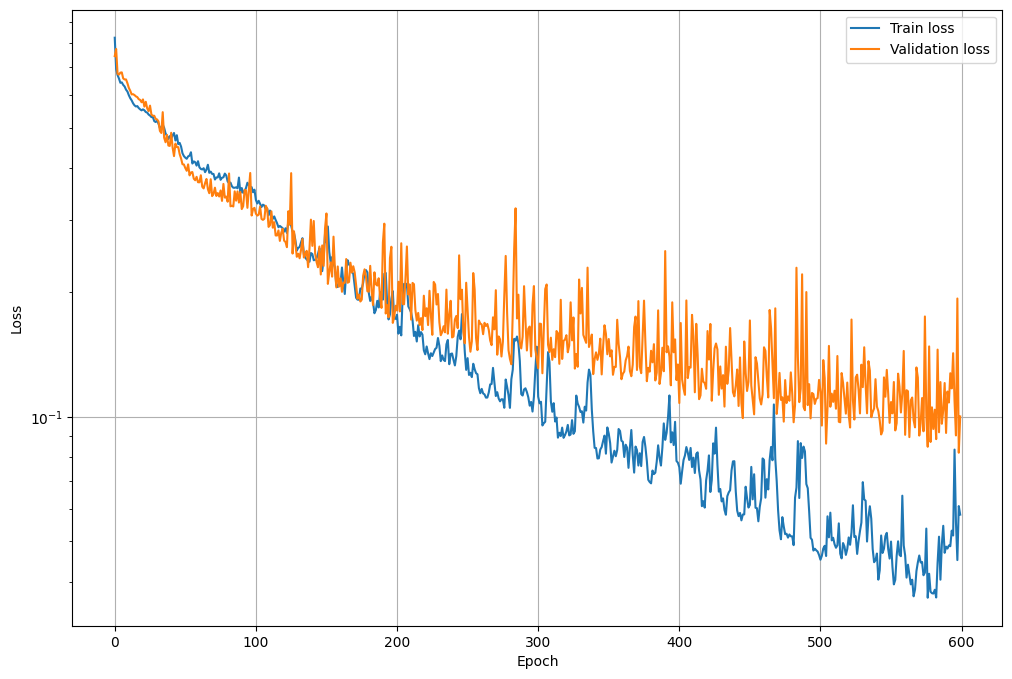

In [ ]:
# Plot losses
plt.figure(figsize=(12,8))
plt.semilogy(train_loss_log, label='Train loss')
plt.semilogy(val_loss_log, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

In [ ]:
#Test data
all_inputs=[]
all_outputs=[]
all_labels=[]

net.eval()
with torch.no_grad():
  for sample_batched in test_dataloader:
    x_batch=sample_batched[0].to(device)
    label_batch=sample_batched[1].to(device)
    out = net(x_batch)

    all_inputs.append(x_batch)
    all_labels.append(label_batch)
    all_outputs.append(out)
  all_inputs = torch.cat(all_inputs)
  all_labels=torch.cat(all_labels)
  all_outputs=torch.cat(all_outputs)
  test_loss = loss_fn(all_outputs, all_labels)
  print(f'Average test loss: {test_loss}')



Average test loss: 0.144563227891922


In [ ]:

 # Get the most probable class inferred by the network
all_output_classes = torch.zeros(all_outputs.shape).to(device)
all_output_classes[all_outputs > 0] = 1

NameError: name 'torch' is not defined

In [ ]:
tot_correct_out = (all_output_classes == all_labels).sum()
test_accuracy = 100 * tot_correct_out / len(all_labels)
print(f"TEST ACCURACY: {test_accuracy:.2f}%")

In [ ]:
### Plot
x1 = all_inputs.squeeze().cpu().numpy()[:, 0]
x2 = all_inputs.squeeze().cpu().numpy()[:, 1]
y_true = all_labels.squeeze().cpu().numpy()
y_pred = all_output_classes.squeeze().cpu().numpy()

fig, ax = plt.subplots(figsize=(12,8))
# Plot predictions
ax.scatter(x1, x2, c=colors[y_pred.astype(np.uint8)], s=10, marker='o')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_title('Network Predictions')
# Mark wrong outputs
error_mask = y_pred != y_true
ax.scatter(x1[error_mask], x2[error_mask], color='red', s=100, marker='x', label='MISCLASSIFIED SAMPLES')
plt.legend()
fig.show()